In [3]:
import sys
sys.path.append('../..')
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from siamese_network_dataset import SiameseNetworkDataset
from torchvision.models.mobilenet import mobilenet_v2
from ContrastiveLossFunction import ContrastiveLoss
from DLBio.pytorch_helpers import get_device, get_num_params
from DLBio.helpers import check_mkdir
from os.path import join
from siamese_network_train import Training

ModuleNotFoundError: No module named 'SiameseNetwork'

In [4]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [6]:
# Set Up All Configurations here
class Config():
    training_dir = "../data/ears/training/"
    testing_dir = "../data/ears/testing/"
    train_batch_size = 32
    
    EPOCHS= 10
    LEARNINGRATE = 0.001

In [8]:
folder_dataset = dset.ImageFolder(root=Config.training_dir)

siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)

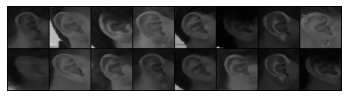

[[1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]]


In [10]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=8)
dataiter = iter(vis_dataloader)

example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

In [12]:
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)

siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=6,batch_size=1,shuffle=True)

In [14]:
# Definde Model and load to device
model = mobilenet_v2(pretrained=True)
model.features[0][0] = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
model.classifier[1] = nn.Linear(in_features=model.classifier[1].in_features, out_features=10)

device = get_device()
print(device)
model.to(device)

contrastiv_loss_siamese = ContrastiveLoss()
optimizer_siamese = optim.Adam(model.parameters(),lr = Config.LEARNINGRATE)

cpu


In [ ]:
training = Training(model=model, optimizer=optimizer_siamese,train_dataloader=train_dataloader, 
                loss_contrastive=contrastiv_loss_siamese)

training(Config.EPOCHS)
show_plot(counter, loss_history)

In [ ]:
dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)

for i in range(10):
    _,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    
    output1 = model(Variable(x0).cuda())
    output2 = model(Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))

